In [4]:
import keyring
from keyrings.alt.file import PlaintextKeyring
# plaintext keyring for dev purposes
keyring.set_keyring(PlaintextKeyring())


In [10]:
from omero.gateway import BlitzGateway
conn = BlitzGateway('', '', host='wss://wsi.lavlab.mcw.edu/omero-wss', secure=True)
conn.connect()

True

In [ ]:
from concurrent.futures import ThreadPoolExecutor, as_completed
import numpy as np
import threading
tpe = ThreadPoolExecutor(4, 'OMERO_RPS')
conn.SERVICE_OPTS.setOmeroGroup('-1')
img_obj = conn.getObject('image', 1000)
def get_tiles(img, tiles, res_lvl=None, rps_bypass=True, conn=None):
    if conn is None:
        conn = img._conn
    local = threading.local()
    def work(pix_id, z, c, t, coord, res_lvl, rps_bypass):
        """runs inside a threadpool to get multiple tiles at a time"""
        if getattr(local, 'rps', None) is None:
            local.rps = conn.c.sf.createRawPixelsStore()
            local.rps.setPixelsId(pix_id, rps_bypass)
            if res_lvl is None:
                res_lvl = local.rps.getResolutionLevels()
                res_lvl -= 1
            local.rps.setResolutionLevel(res_lvl)
            
        return local.rps.getTile(z, c, t, *coord), (z, c, t, coord)
    def cleanup():
        """cleans out the raw pixels stores after work is done"""
        if hasattr(local, 'rps'):
            local.rps.close()
            delattr(local, 'rps')
    futures = [tpe.submit(work, img.getPrimaryPixels().getId(), z, c, t, coord, res_lvl, rps_bypass) for z, c, t, coord in tiles]
    try:
        for future in as_completed(futures):
            raw_data, (z,c,t,coord) = future.result()
            processed_data = np.frombuffer(raw_data, dtype=np.uint8).reshape(coord[3],coord[2])
            yield processed_data, (z,c,t,coord)
    finally:
        futures = [tpe.submit(cleanup) for x in range(tpe._max_workers)]
        for future in as_completed(futures):
            future.result()
for tile in get_tiles(img_obj, [(0,0,0,(0,0,1024,1024))]*1000):
    print(tile)

In [1]:
import sys
from enum import Enum

class ThreadingEnviromentalVariables(Enum):
    """Converts a module name into the environemental variable for controlling max cpu threads.
    Used for passing the module thread configurations into dependencies.
    """
    PYVIPS = "VIPS_CONCURRENCY"

    @staticmethod
    def is_module_imported(module_name: str) -> bool:
        """Checks if a given module is imported by the module's name.
        Used to warn users if we are trying to configure a module that is already imported.

        :param module_name: name of the given module, ex. "pyvips"
        :type module_name: str
        :return: Bool representing whether the module has already been imported
        :rtype: bool
        """
        return module_name in sys.modules
print(ThreadingEnviromentalVariables["PYVIPS"])
for lib in list(ThreadingEnviromentalVariables):
    print(lib.value)

ThreadingEnviromentalVariables.PYVIPS
VIPS_CONCURRENCY


In [1]:
import SimpleITK as sitk
rad = sitk.ReadImage('T2.nii.gz')
rad

ConnectionRefusedException: Ice.ConnectionRefusedException:
Connection refused

In [4]:
import numpy as np
np.sum(rad)

13127699484.0

In [5]:
import pyvips as pv
hist = pv.Image.new_from_file('large_recon_10_nowhite.tiff')
hist

<pyvips.Image 15828x24250 uchar, 3 bands, srgb>

In [9]:
np.max(hist)

Error: max does not support optional argument axis
  

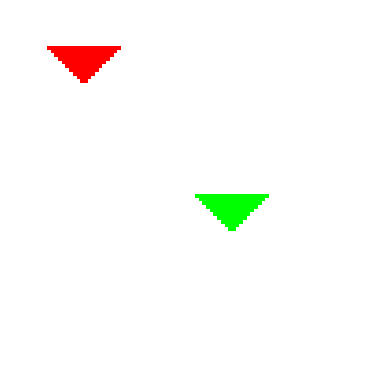

In [18]:
import pyvips as pv
import matplotlib.pyplot as plt
import numpy as np
from typing import Union


def draw_shapes(
    img: Union[np.ndarray, pv.Image],
    shape_points: list[tuple[int, tuple[int, int, int], list[tuple[int, int]]]],
) -> Union[np.ndarray, pv.Image]:
    """
    Draws a list of shape points onto the input image using PyVips with SVG.

    .. warning::
       No safety checks! Make sure img and shape_points are for the same downsample factor!

    :param img: Input image as a NumPy array or pyvips Image.
    :type img: Union[np.ndarray, pyvips.Image]
    :param shape_points: List of tuples containing shape ID, RGB color, and list of points.
                         Expected to use output from lavlab.omero_util.getShapesAsPoints.
    :type shape_points: List[Tuple[int, Tuple[int, int, int], List[Tuple[int, int]]]]
    :returns: Modified image with shapes drawn, same type as input.
    :rtype: Union[np.ndarray, pyvips.Image]
    """
    if isinstance(img, np.ndarray):
        # Convert numpy array to pyvips Image
        img = pv.Image.new_from_array(img)

    width = img.width
    height = img.height

    svg_header = (
        f'<svg viewBox="0 0 {width} {height}" '
        f'xmlns="http://www.w3.org/2000/svg" '
        f'shape-rendering="crispEdges">'
    )
    svg_shapes = ""

    for _, rgb, xy in shape_points:
        hex_color = f'#{rgb[0]:02x}{rgb[1]:02x}{rgb[2]:02x}'
        points = " ".join([f"{x},{y}" for y, x in xy])
        svg_shapes += f'<polygon points="{points}" fill="{hex_color}"/>'

    svg_footer = '</svg>'
    svg = svg_header + svg_shapes + svg_footer
    svg_img = pv.Image.svgload_buffer(svg.encode('utf-8'))

    # Composite the SVG image over the original image
    composite_img = img.composite2(svg_img, 'over', x=0, y=0)

    # Return the modified image in the same type as the input
    if isinstance(img, np.ndarray):
        return composite_img.numpy()
    else:
        return composite_img
# Define the SVG data for a filled polygon
svg_data = """
<svg viewBox="0 0 100 100" xmlns="http://www.w3.org/2000/svg">
  <polygon points="50,10 90,90 10,90" fill="#009900"/>
</svg>
"""

# Load the SVG data into a pyvips image
image = pv.Image.svgload_buffer(svg_data.encode('utf-8'))
image = image.resize(10)

# Convert the pyvips image to a NumPy array
np_image = np.ndarray(buffer=image.write_to_memory(),
                      dtype=np.uint8,
                      shape=[image.height, image.width, image.bands])

img = np.ones((100, 100, 3), dtype=np.uint8) * 255
shapes = [
    (1, (255, 0, 0), [(10, 10), (20, 20), (10, 30)]),
    (2, (0, 255, 0), [(50, 50), (60, 60), (50, 70)]),
]
modified_img = draw_shapes(img, shapes)
# Display the image using matplotlib
plt.imshow(modified_img)
plt.axis('off')  # Hide the axes
plt.show()


In [ ]:
import numpy as np
import pyvips

def apply_mask(img: np.ndarray, mask: np.ndarray) -> np.ndarray:
    """
    Applies a binary mask to an image using PyVips.

    Parameters
    ----------
    img : np.ndarray
        Image as a NumPy array.
    mask : np.ndarray
        Binary mask as a NumPy array (same dimensions as img).

    Returns
    -------
    np.ndarray
        Image with the mask applied.
    """
    assert isinstance(img, np.ndarray), "img must be a numpy.ndarray"
    assert isinstance(mask, np.ndarray), "mask must be a numpy.ndarray"

    # Convert numpy arrays to pyvips images
    vips_img = pyvips.Image.new_from_array(img)
    vips_mask = pyvips.Image.new_from_array(mask)

    # Create a masked image using PyVips
    masked_img = vips_img * vips_mask

    # Convert the PyVips image back to a numpy array
    return masked_img.numpy()

# Example usage
img = np.random.randint(0, 255, (100, 100, 3), dtype=np.uint8)
mask = np.zeros((100, 100, 3), dtype=np.uint8)
mask[25:75, 25:75, :] = 1  # Create a square mask
masked_img = apply_mask(img, mask)
plt.imshow(masked_img)
plt.axis('off')  # Hide the axes
plt.show()


In [1]:
from omero.gateway import BlitzGateway
conn = BlitzGateway('', '', host='wss://wsi.lavlab.mcw.edu/omero-wss', secure=True)
conn.connect()

True

In [ ]:
!pip3 install -U ipywidgets==7.7.1 pycairo mplcairo

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as ipyw
%matplotlib widget

class ImageSliceViewer3D:
    orient = {"y-z": [1, 2, 0], "z-x": [2, 0, 1], "x-y": [0, 1, 2]}
    
    def __init__(self, volume, figsize=(8, 8), cmap='plasma', downsample_rate=1):
        # Downsample and convert the volume to uint8
        self.volume = ((volume[::downsample_rate, ::downsample_rate, ::downsample_rate] - volume.min()) /
                       (volume.ptp()) * 255).astype(np.uint8)
        self.figsize = figsize
        self.cmap = cmap
        self.v = [np.min(self.volume), np.max(self.volume)]

        # Radio buttons for selecting the slice plane
        self.view_widget = ipyw.RadioButtons(
            options=['x-y', 'y-z', 'z-x'], value='x-y',
            description='Slice plane selection:', disabled=False,
            style={'description_width': 'initial'})

        # Slider for selecting the slice within the selected plane
        self.slice_slider = ipyw.IntSlider(min=0, max=self.volume.shape[2]-1, step=1,
                                           continuous_update=True, description='Image Slice:')

        # Display widgets
        display(self.view_widget, self.slice_slider)

        # Register event handlers
        self.view_widget.observe(self.update_view, names='value')
        self.slice_slider.observe(self.update_slice, names='value')

        # Initialize the plot
        self.fig, self.ax = plt.subplots(figsize=self.figsize)
        self.img = self.ax.imshow(self.get_slice('x-y', 0), cmap=self.cmap, vmin=self.v[0], vmax=self.v[1])
        self.cbar = self.fig.colorbar(self.img, ax=self.ax)
        self.ax.set_title('x-y - Slice 0')
        self.update_view({'new': self.view_widget.value})

    def get_slice(self, view, z):
        vol = np.transpose(self.volume, self.orient[view])
        return vol[:, :, z]

    def update_view(self, change):
        view = change['new']
        self.current_view = view
        self.slice_slider.max = self.volume.shape[self.orient[self.current_view][2]] - 1
        self.slice_slider.value = 0  # Reset slider to show the first slice
        self.update_slice({'new': self.slice_slider.value})

    def update_slice(self, change):
        z = change['new']
        self.img.set_data(self.get_slice(self.current_view, z))
        self.ax.set_title(f'{self.current_view} - Slice {z}')
        self.img.set_clim(self.v[0], self.v[1])  # Predefined color limits
        self.fig.canvas.draw_idle()

x = np.random.rand(512,512,36)

ImageSliceViewer3D(x)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as ipyw

# Use `%matplotlib inline` for static plots
# %matplotlib inline

class ImageSliceViewer3D:
    orient = {"y-z": [1, 2, 0], "z-x": [2, 0, 1], "x-y": [0, 1, 2]}
    def __init__(self, volume, figsize=(8, 8), cmap='plasma', downsample_rate=1):  # More aggressive downsampling
        # Downsample and convert the volume to uint8
        self.volume = ((volume[::downsample_rate, ::downsample_rate, ::downsample_rate] - volume.min()) / 
                       (volume.ptp()) * 255).astype(np.uint8)
        self.figsize = figsize
        self.cmap = cmap
        self.v = [np.min(self.volume), np.max(self.volume)]

        # Radio buttons for selecting the slice plane
        self.view_widget = ipyw.RadioButtons(
            options=['x-y', 'y-z', 'z-x'], value='x-y',
            description='Slice plane selection:', disabled=False,
            style={'description_width': 'initial'})

        # Slider for selecting the slice within the selected plane
        self.slice_slider = ipyw.IntSlider(min=0, max=self.volume.shape[2]-1, step=1,
                                           continuous_update=True, description='Image Slice:')

        # Output widget for displaying the image
        self.out = ipyw.Output()

        # Display widgets
        display(self.view_widget, self.slice_slider, self.out)

        # Register event handlers
        self.view_widget.observe(self.update_view, names='value')
        self.slice_slider.observe(self.update_slice, names='value')

        # Initialize the plot
        self.fig, self.ax = plt.subplots(figsize=self.figsize)
        self.img = self.ax.imshow(self.get_slice('x-y', 0), cmap=self.cmap, vmin=self.v[0], vmax=self.v[1])
        self.cbar = self.fig.colorbar(self.img, ax=self.ax)
        self.ax.set_title('x-y - Slice 0')
        self.update_view({'new': self.view_widget.value})

    def get_slice(self, view, z):
        vol = np.transpose(self.volume, self.orient[view])
        return vol[:, :, z]

    def update_view(self, change):
        view = change['new']
        self.current_view = view
        self.slice_slider.max = self.volume.shape[self.orient[self.current_view][2]] - 1
        self.slice_slider.value = 0  # Reset slider to show the first slice
        self.update_slice({'new': self.slice_slider.value})

    def update_slice(self, change):
        z = change['new']
        self.img.set_data(self.get_slice(self.current_view, z))
        self.ax.set_title(f'{self.current_view} - Slice {z}')
        self.ax.set_xlim(0, self.img.get_array().shape[1])  # Predefined x-axis limits
        self.ax.set_ylim(self.img.get_array().shape[0], 0)  # Predefined y-axis limits
        self.img.set_clim(self.v[0], self.v[1])  # Predefined color limits
        self.fig.canvas.draw_idle()

# Create a 3D array with random numbers
x = np.random.rand(256,256,96)

ImageSliceViewer3D(x)

In [ ]:
# %config InlineBackend.figure_format = 'retina'
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as ipyw

# Use `%matplotlib inline` for static plots
# %matplotlib inline

class ImageSliceViewer3D:
    orient = {"y-z": [1, 2, 0], "z-x": [2, 0, 1], "x-y": [0, 1, 2]}
    def __init__(self, volume, figsize=(8, 8), cmap='plasma', downsample_rate=1):
        # Downsample and convert the volume to uint8
        self.volume = ((volume[::downsample_rate, ::downsample_rate, ::downsample_rate] - volume.min()) / 
                       (volume.ptp()) * 255).astype(np.uint8)
        self.figsize = figsize
        self.cmap = cmap
        self.v = [np.min(self.volume), np.max(self.volume)]

        # Radio buttons for selecting the slice plane
        self.view_widget = ipyw.RadioButtons(
            options=['x-y', 'y-z', 'z-x'], value='x-y',
            description='Slice plane selection:', disabled=False,
            style={'description_width': 'initial'})

        # Slider for selecting the slice within the selected plane
        self.slice_slider = ipyw.IntSlider(min=0, max=self.volume.shape[2]-1, step=1,
                                           continuous_update=True, description='Image Slice:')

        # Output widget for displaying the image
        self.out = ipyw.Output()

        # Display widgets
        display(self.view_widget, self.slice_slider, self.out)

        # Register event handlers
        self.view_widget.observe(self.update_view, names='value')
        self.slice_slider.observe(self.update_slice, names='value')

        # Initialize the view
        self.update_view({'new': self.view_widget.value})

    def get_slice(self, view, z):
        vol = np.transpose(self.volume, self.orient[view])
        return vol[:, :, z]

    def update_view(self, change):
        view = change['new']
        self.current_view = view
        self.slice_slider.max = self.volume.shape[self.orient[self.current_view][2]] - 1
        self.slice_slider.value = 0  # Reset slider to show the first slice
        self.update_slice({'new': self.slice_slider.value})

    def update_slice(self, change):
        z = change['new']
        with self.out:
            self.out.clear_output(wait=True)
            plt.figure(figsize=self.figsize)
            plt.imshow(self.get_slice(self.current_view, z), cmap=self.cmap, vmin=self.v[0], vmax=self.v[1])
            plt.colorbar()
            plt.show()





# Create a 3D array with random numbers
x = np.random.rand(256,256,96)

ImageSliceViewer3D(x)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.widgets import Slider, Button
%matplotlib widget

# Generate 3D data (you would replace this with your actual 3D image data)
volume_data = np.random.rand(100, 100, 100)

# Define initial parameters
init_slice = volume_data.shape[0] // 2  # Initial slice index

# Create the figure and the image slice that we will manipulate
fig, ax = plt.subplots()
current_slice = volume_data[init_slice, :, :]
im = ax.imshow(current_slice, cmap='gray', interpolation='nearest')

# adjust the main plot to make room for the slider
fig.subplots_adjust(left=0.25, bottom=0.25)

# Make a slider to control the slice index
ax_slice = fig.add_axes([0.25, 0.1, 0.65, 0.03])
slice_slider = Slider(
    ax=ax_slice,
    label='Slice',
    valmin=0,
    valmax=volume_data.shape[0] - 1,
    valinit=init_slice,
    valfmt='%d'
)

# The function to be called anytime the slider's value changes
def update(val):
    slice_index = int(slice_slider.val)
    current_slice = volume_data[slice_index, :, :]
    im.set_data(current_slice)
    fig.canvas.draw_idle()

# Register the update function with the slider
slice_slider.on_changed(update)

# Create a button to reset the slice index to initial value
reset_ax = fig.add_axes([0.8, 0.025, 0.1, 0.04])
reset_button = Button(reset_ax, 'Reset', hovercolor='0.975')

def reset(event):
    slice_slider.reset()
reset_button.on_clicked(reset)

plt.show()


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as ipyw
from ipywidgets import VBox, HBox
import matplotlib.animation as animation
%matplotlib widget

class MultiImageSliceViewer3D:
    """Allows thumbing through multiple volumes' slices interactively, with the ability to lock the views."""
    
    def __init__(self, volumes, figsize=(6, 6), cmap='plasma', downsample_rate=1):
        self.volumes = [((vol[::downsample_rate, ::downsample_rate, ::downsample_rate] - vol.min()) /
                         vol.ptp() * 255).astype(np.uint8) for vol in volumes]
        self.figsize = figsize
        self.cmap = cmap
        self.num_images = len(self.volumes)
        self.v = [np.min([np.min(vol) for vol in self.volumes]), np.max([np.max(vol) for vol in self.volumes])]
        self.lock_views = False
        self.previous_slice_indices = [0] * self.num_images

        self.slice_sliders = []
        self.axs = []
        self.imgs = []

        self.fig, axs = plt.subplots(1, self.num_images, figsize=(self.figsize[0] * self.num_images, self.figsize[1]))
        
        if not isinstance(axs, np.ndarray):
            axs = [axs]

        for i, vol in enumerate(self.volumes):
            slider = ipyw.IntSlider(min=0, max=vol.shape[2]-1, step=1, continuous_update=True, description=f'Image {i+1}:')
            self.slice_sliders.append(slider)

            ax = axs[i]
            self.axs.append(ax)

            img = ax.imshow(self._get_slice(vol, 0), cmap=self.cmap, vmin=self.v[0], vmax=self.v[1])
            self.imgs.append(img)
            self.fig.colorbar(img, ax=ax)
            ax.set_title(f'Image {i+1} - Slice 0')

        self.out = ipyw.Output()
        with self.out:
            plt.show()

        self.lock_checkbox = ipyw.Checkbox(value=False, description='Lock Views')

        sliders_box = HBox([slider for slider in self.slice_sliders])
        display(VBox([self.out, sliders_box, self.lock_checkbox]))

        for slider in self.slice_sliders:
            slider.observe(self._update_slices, names='value')

        self.lock_checkbox.observe(self._toggle_lock, names='value')

        # Connect events to synchronize zoom and pan
        self.fig.canvas.mpl_connect('button_release_event', self._sync_axes)
        self.fig.canvas.mpl_connect('motion_notify_event', self._sync_axes)

    def _get_slice(self, volume, z):
        return volume[:, :, z]

    def _update_slices(self, change):
        slider_index = self.slice_sliders.index(change['owner'])
        new_index = change['new']
        relative_change = new_index - self.previous_slice_indices[slider_index]
        self.previous_slice_indices[slider_index] = new_index

        for i, vol in enumerate(self.volumes):
            if self.lock_views and i != slider_index:
                self.slice_sliders[i].unobserve(self._update_slices, names='value')
                new_slider_value = self.slice_sliders[i].value + relative_change
                new_slider_value = np.clip(new_slider_value, 0, self.slice_sliders[i].max)
                self.slice_sliders[i].value = new_slider_value
                self.slice_sliders[i].observe(self._update_slices, names='value')

            with self.out:
                self.imgs[i].set_data(self._get_slice(vol, self.slice_sliders[i].value))
                self.axs[i].set_title(f'Image {i+1} - Slice {self.slice_sliders[i].value}')
                self.imgs[i].set_clim(self.v[0], self.v[1])  # Predefined color limits

        self.fig.canvas.draw_idle()

    def _toggle_lock(self, change):
        self.lock_views = change['new']

    def _sync_axes(self, event):
        if not self.lock_views or event.inaxes is None:
            return
        
        for ax in self.axs:
            if ax is not event.inaxes:
                ax.set_xlim(event.inaxes.get_xlim())
                ax.set_ylim(event.inaxes.get_ylim())
        self.fig.canvas.draw_idle()


# Example usage
x = [np.random.rand(256, 256, 36), np.random.rand(256, 256, 36)]
MultiImageSliceViewer3D(x)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as ipyw
from ipywidgets import VBox
from IPython.display import display
%matplotlib widget

class ImageSliceViewer3D:
    def __init__(self, volume, figsize=(8, 8), cmap='plasma', downsample_rate=1):
        # Downsample and convert the volume to uint8
        self.volume = ((volume[::downsample_rate, ::downsample_rate, ::downsample_rate] - volume.min()) /
                       (volume.ptp()) * 255).astype(np.uint8)
        self.figsize = figsize
        self.cmap = cmap
        self.v = [np.min(self.volume), np.max(self.volume)]

        # Slider for selecting the slice within the selected plane
        self.slice_slider = ipyw.IntSlider(min=0, max=self.volume.shape[2]-1, step=1,
                                           continuous_update=True, description='Image Slice:')

        # Initialize the plot
        self.fig, self.ax = plt.subplots(figsize=self.figsize)
        self.img = self.ax.imshow(self.get_slice(0), cmap=self.cmap, vmin=self.v[0], vmax=self.v[1])
        self.cbar = self.fig.colorbar(self.img, ax=self.ax)
        self.ax.set_title(f'Slice 0')

        # Output widget
        self.out = ipyw.Output()
        with self.out:
            plt.show()

        # Layout widgets and display
        display(VBox([self.out, self.slice_slider]))

        # Register event handlers
        self.slice_slider.observe(self.update_slice, names='value')

    def get_slice(self, z):
        return self.volume[:, :, z]

    def update_slice(self, change):
        z = change['new']
        with self.out:
            self.img.set_data(self.get_slice(z))
            self.ax.set_title(f'Slice {z}')
            self.img.set_clim(self.v[0], self.v[1])  # Predefined color limits
            self.fig.canvas.draw_idle()

# Example usage
x = np.random.rand(256, 256, 36)
ImageSliceViewer3D(x)


In [ ]:
import numpy as np
from src.lavlab.jupyter.images import ImageSliceViewer3D

x = np.random.rand(256, 256, 36)
ImageSliceViewer3D(x)

In [12]:
import pydicom.data
pydicom.data.get_testdata_files('dicomdirtests/98892003/MR1')

['/home/vscode/.local/lib/python3.11/site-packages/pydicom/data/test_files/dicomdirtests/98892003/MR1']

In [14]:
import os
from pydicom.data import get_testdata_file, get_testdata_files

dicom_dir = get_testdata_files('dicomdirtests/98892003/MR1')[0]
# Get a list of all DICOM files in the directory
dicom_files = [os.path.join(dicom_dir, filename) for filename in os.listdir(dicom_dir)]

# Read the DICOM directory
dicom_dataset = pydicom.dcmread(dicom_files)

# Access DICOM files and their attributes
for ds in dicom_dataset:
    # Print some attributes of the DICOM file
    print("Patient ID:", ds.PatientID)
    print("Study Description:", ds.StudyDescription)
    print("Series Description:", ds.SeriesDescription)
    print("Instance Number:", ds.InstanceNumber)

TypeError: dcmread: Expected a file path or a file-like, but got list

In [2]:
import pyvips as pv
img =pv.Image.black(100,100)

In [6]:
img.shiftx(10,10)

AttributeError: 

In [1]:
from omero.gateway import BlitzGateway
import omero

c = omero.client(host='wss://idr.openmicroscopy.org/omero-ws', port=443)
c.enableKeepAlive(300)
c.createSession('public', 'public')
conn = BlitzGateway(client_obj=c)

PermissionDeniedException: exception ::Glacier2::PermissionDeniedException
{
    reason = internal server error
}

In [11]:
img = conn.getObject('image', '362')

In [13]:
img.getPixelSizeX()

0.2

In [14]:
img.loadOriginalMetadata()

(None,
 [('BitsPerSample', '8'),
  ('Compress Method', 'Lossy'),
  ('Compress Option', 'JPEG'),
  ('Compression', 'JPEG'),
  ('DateTime', '2021:05:05 11:24:56'),
  ('DeviceID', 'NC'),
  ('Image Dimensions', '137240x227547 Pixels'),
  ('Image Quality', '0.900000'),
  ('ImageID', '{103F1576-58EA-4613-8BF7-C617D07A05D5}'),
  ('ImageLength', '227547'),
  ('ImageWidth', '137240'),
  ('Instrument Make', 'Huron Digital Pathology'),
  ('Instrument Model', 'NC'),
  ('MetaDataPhotometricInterpretation', 'RGB'),
  ('MetaMorph', 'no'),
  ('NewSubfileType', '2'),
  ('NumberOfChannels', '3'),
  ('Orientation', '1st row - top; 1st column - left'),
  ('PageNumber', '0 6'),
  ('PhotometricInterpretation', 'YCbCr'),
  ('PlanarConfiguration', 'Chunky'),
  ('ReferenceBlackWhite', '0'),
  ('Resolution', '0.20 um'),
  ('ResolutionUnit', 'Centimeter'),
  ('SamplesPerPixel', '3'),
  ('Scan Duration', '00:12:26'),
  ('Scan Size', '27.45x45.51 mm'),
  ('Scan Started', '2021:05:05 11:24:56'),
  ('Software', 'MAC

In [3]:
class test:
    def __init__(self):
        print(str(self.__class__.__name__))
test()

test


In [1]:
import multiprocessing

In [2]:
multiprocessing.cpu_count()

95

In [3]:
if not asdf:
    print("nice")

NameError: name 'asdf' is not defined